In [2]:
from tqdm import tqdm
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
#from tensorflow.keras import preprocessing 
import keras
#from tensorflow.keras import backend as K
#from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization, LayerNormalization
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.callbacks import EarlyStopping
#import imutils
#import tensorflow as tf
#from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.applications.resnet50 import ResNet50 as ResNet50
#from tensorflow.keras.applications.resnet50 import decode_predictions,preprocess_input

#init_notebook_mode(connected=True)
RANDOM_SEED = 123

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<class 'numpy.ndarray'>


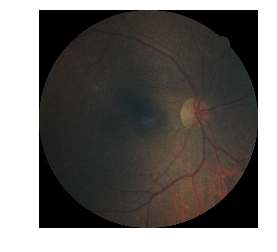

In [3]:
data_train_path='/kaggle/input/diabetic-retinopathy-small-dataset-2/'+'train_balanced_0_1'
#path+'/'+'train_balanced_0_1'
data_val_path='/kaggle/input/diabetic-retinopathy-small-dataset-2/'+'val_balanced_0_1'
data_test_path='/kaggle/input/diabetic-retinopathy-small-dataset-2/'+'test_splitted'
# example image
#img = cv2.imread(data_train_path+'/Healthy/'+labels['image'].iloc[0]+'.jpeg')
img = cv2.imread(data_train_path+'/Healthy/'+'10_right.jpeg')
print(type(img))
plt.axis("off")
#plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

_____

In [4]:
# copy the weights and configurations for the pre-trained models
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [6]:
classes = ['Healthy', 'Not Healthy']

# Model training

In [7]:
from keras import preprocessing 

In [12]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np

In [13]:
# to increase the amount of images
data_gen = preprocessing.image.ImageDataGenerator(
     preprocessing_function=preprocess_input,
     #rotation_range=15,
     #width_shift_range=0.05,
     #height_shift_range=0.05,
     #shear_range=0.05,
     #horizontal_flip=True,
     #vertical_flip=True,  
     #rescale=1 / 255.0,
     fill_mode="nearest",
     #validation_split=0.20
)

val_datagen = preprocessing.image.ImageDataGenerator(
     preprocessing_function=preprocess_input)
     #rescale=1 / 255.0)

test_datagen = preprocessing.image.ImageDataGenerator(
     preprocessing_function=preprocess_input)
     #rescale=1 / 255.0)
     
#for i in range(30):
#    image.next()     

In [14]:
batch_size = 50

train_generator = data_gen.flow_from_directory(
    directory=data_train_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = data_gen.flow_from_directory(
    directory=data_val_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    #subset='validation',
    shuffle=True,
    seed=42
)
test_generator =test_datagen.flow_from_directory(
    directory=data_test_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)


Found 3162 images belonging to 2 classes.
Found 678 images belonging to 2 classes.
Found 676 images belonging to 2 classes.


In [15]:
train_set_size=3162
val_set_size=678
test_set_size=676

# Validation Set
We do not perform augmentation at all on these images

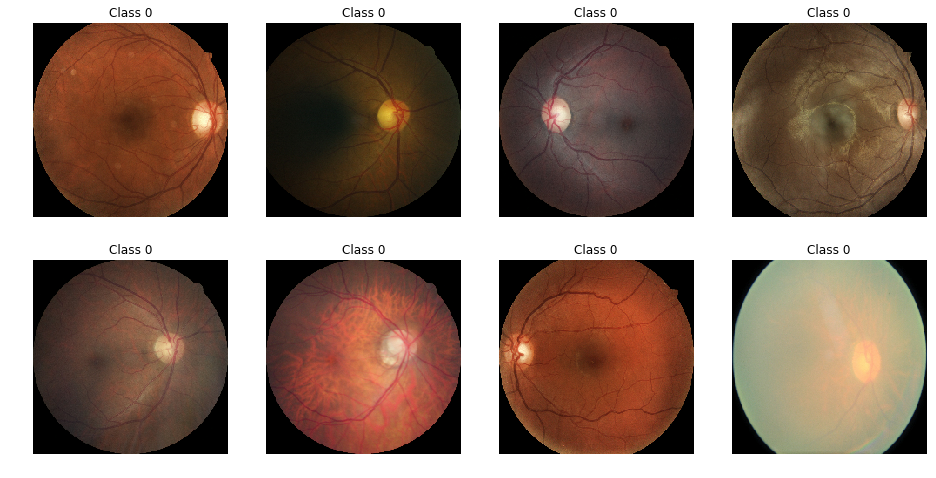

In [16]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    #print((c_x, c_y, c_ax))
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Class {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

# Attention Model
Global Average Pooling

In [19]:
from keras import backend as K
K.clear_session()

In [20]:
#from keras.applications.vgg16 import VGG16 as PTModel
#from keras.applications.xception import Xception as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 5, 5, 2048)   8192        inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 5, 5, 2048)   0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_95 

In [21]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/callbacks.py:919: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.


In [22]:
!rm -rf ~/.keras # clean up before starting training

In [23]:
history= retina_model.fit_generator(train_generator, 
                           steps_per_epoch=None,
                           validation_data = valid_generator, 
                           #validation_steps = valid_df.shape[0]//batch_size,
                           epochs = 20, 
                           callbacks = callbacks_list,
                           workers = 0, # tf-generators are not thread-safe
                           use_multiprocessing=True, 
                           max_queue_size = 0
                            )

Epoch 1/20
64/64 [==============================] - 457s 7s/step - loss: 0.7198 - categorical_accuracy: 0.5531 - top_2_accuracy: 1.0000 - val_loss: 0.7113 - val_categorical_accuracy: 0.5546 - val_top_2_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.71135, saving model to retina_weights.best.hdf5
Epoch 2/20
64/64 [==============================] - 380s 6s/step - loss: 0.6387 - categorical_accuracy: 0.6333 - top_2_accuracy: 1.0000 - val_loss: 1.3495 - val_categorical_accuracy: 0.5192 - val_top_2_accuracy: 1.0000

Epoch 00002: val_loss did not improve
Epoch 3/20
64/64 [==============================] - 381s 6s/step - loss: 0.6079 - categorical_accuracy: 0.6650 - top_2_accuracy: 1.0000 - val_loss: 0.8791 - val_categorical_accuracy: 0.5693 - val_top_2_accuracy: 1.0000

Epoch 00003: val_loss did not improve
Epoch 4/20
64/64 [==============================] - 381s 6s/step - loss: 0.5873 - categorical_accuracy: 0.6885 - top_2_accuracy: 1.0000 - val_loss: 1.2757 - val_categorica

In [25]:
# load the best version of the model
retina_model.load_weights(weight_path)
history.model.save('vgg16.h5')

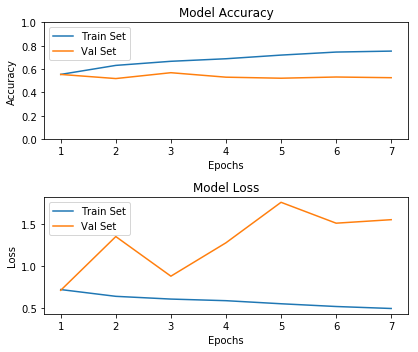

In [26]:
 # plot model performance
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(6,5))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.ylim([0,1])


plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
#plt.ylim([0,7])

plt.tight_layout()
plt.show()

# Show Attention

In [27]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

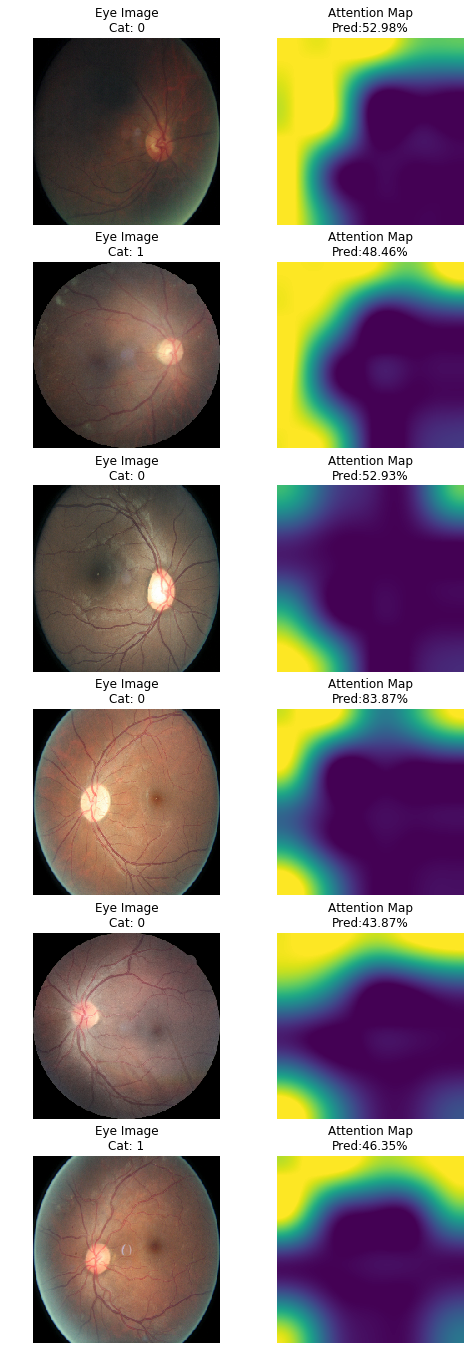

In [28]:
import keras.backend as K
rand_idx = np.random.choice(range(train_set_size), size = 6)
attn_func = K.function(inputs = [retina_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):#
    image, label = train_generator._get_batches_of_transformed_samples(np.array([c_idx]))

    cur_img = image
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(label)
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

# Evaluate the results


In [29]:
from sklearn.metrics import accuracy_score, classification_report

image_name_list=[]
label_list=[]
pred_prob_list=[]
pred_label_list=[]
sick_score=[]
sick_score_2=[]
for index in range(train_set_size):
    image, label = train_generator._get_batches_of_transformed_samples(np.array([index]))
    label_list.append(label[0][0])
    image_name = train_generator.filenames[index]
    image_name_list.append(image_name)
    pred_im=retina_model.predict(image, verbose = False)
    [a1,a2]=[pred_im[0][0],pred_im[0][1]]
    pred_prob_list.append([a1,a2])
    sick_score.append(a1)
    sick_score_2.append(a2)
    if a1>=0.5:
        pred_label_list.append(1)
    elif a1<0.5:
        pred_label_list.append(0)

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(label_list, pred_label_list)))
print(classification_report(label_list, pred_label_list))

Accuracy on Test Data: 0.56%
             precision    recall  f1-score   support

        0.0       0.60      0.36      0.45      1581
        1.0       0.54      0.76      0.64      1581

avg / total       0.57      0.56      0.54      3162



Text(0.5,1,'Train set')

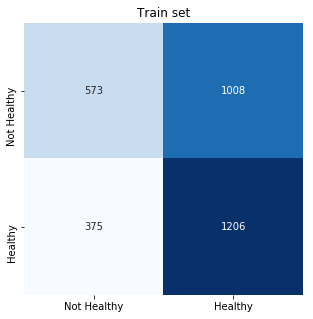

In [31]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix( label_list, pred_label_list) 
fig, ax = plt.subplots(figsize=(5,5)) 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_mtx.flatten()]
x_axis_labels=['Not Healthy',  'Healthy']
y_axis_labels=['Not Healthy',  'Healthy']  
sns.heatmap(confusion_mtx,
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#cm = ConfusionMatrixDisplay(confusion_mtx, display_labels=classes)
#cm.plot(cmap=plt.cm.Blues)
plt.title('Train set')

# ROC Curve for healthy vs sick

Text(0.5,1,'Train set')

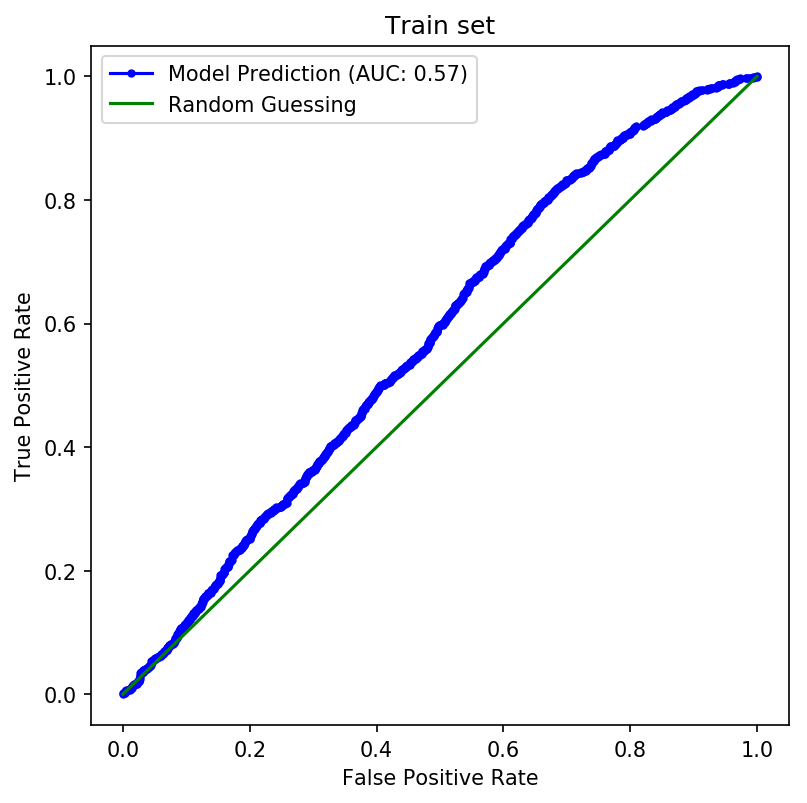

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = label_list
#sick_score = np.sum(pred_prob_list[:,1:],1)
fpr, tpr, _ = roc_curve(label_list, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
plt.title('Train set')

Vsalidation

In [33]:
from sklearn.metrics import accuracy_score, classification_report

image_name_list=[]
label_list=[]
pred_prob_list=[]
pred_label_list=[]
sick_score=[]
for index in range(val_set_size):
    image, label =valid_generator._get_batches_of_transformed_samples(np.array([index]))
    label_list.append(label[0][0])
    image_name = valid_generator.filenames[index]
    image_name_list.append(image_name)
    pred_im=retina_model.predict(image, verbose = False)
    [a1,a2]=[pred_im[0][0],pred_im[0][1]]
    pred_prob_list.append([a1,a2])
    sick_score.append(a1)
    sick_score_2.append(a2)
    if a1>=0.5:
        pred_label_list.append(1)
    elif a1<0.5:
        pred_label_list.append(0)

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(label_list, pred_label_list)))
print(classification_report(label_list, pred_label_list))

Accuracy on Test Data: 0.55%
             precision    recall  f1-score   support

        0.0       0.58      0.38      0.46       339
        1.0       0.54      0.73      0.62       339

avg / total       0.56      0.55      0.54       678



Text(0.5,1,'Validation set')

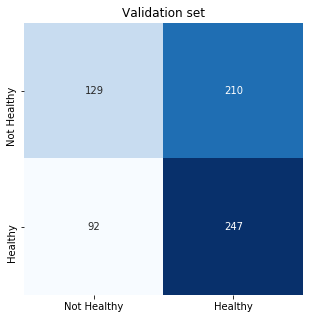

In [35]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix( label_list, pred_label_list) 
fig, ax = plt.subplots(figsize=(5,5)) 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_mtx.flatten()]
x_axis_labels=['Not Healthy',  'Healthy']
y_axis_labels=['Not Healthy',  'Healthy']  
sns.heatmap(confusion_mtx,
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#cm = ConfusionMatrixDisplay(confusion_mtx, display_labels=classes)
#cm.plot(cmap=plt.cm.Blues)
plt.title('Validation set')

Text(0.5,1,'Train set')

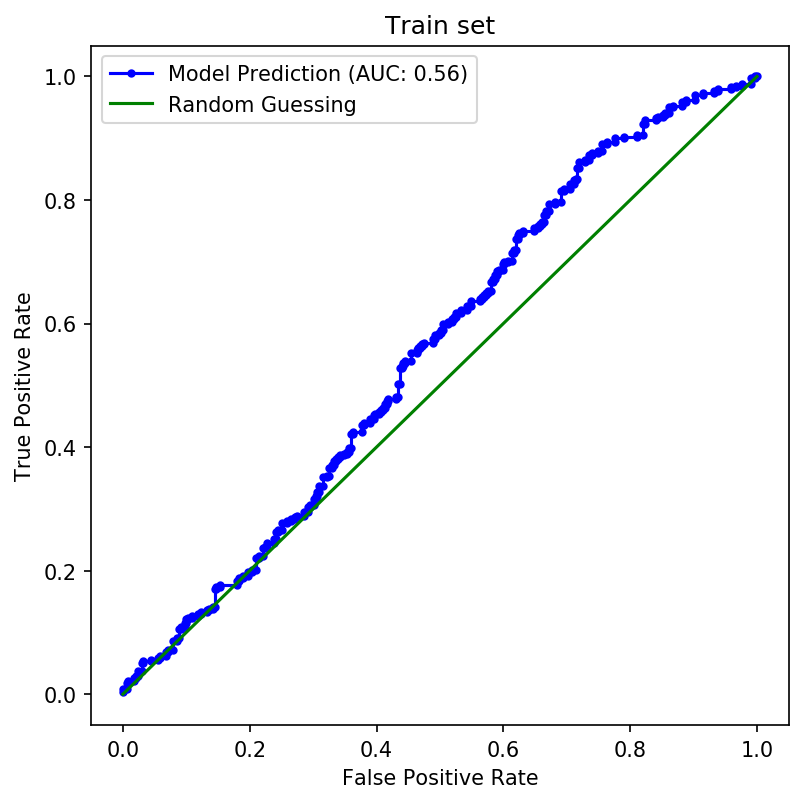

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = label_list
#sick_score = np.sum(pred_prob_list[:,1:],1)
fpr, tpr, _ = roc_curve(label_list, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
plt.title('Train set')

### Test

In [37]:
from sklearn.metrics import accuracy_score, classification_report

image_name_list=[]
label_list=[]
pred_prob_list=[]
pred_label_list=[]
sick_score=[]
sick_score_2=[]
for index in range(test_set_size):
    image, label = test_generator._get_batches_of_transformed_samples(np.array([index]))
    label_list.append(label[0][0])
    image_name = test_generator.filenames[index]
    image_name_list.append(image_name)
    pred_im=retina_model.predict(image, verbose = False)
    [a1,a2]=[pred_im[0][0],pred_im[0][1]]
    pred_prob_list.append([a1,a2])
    sick_score.append(a1)
    sick_score_2.append(a2)
    if a1>=0.5:
        pred_label_list.append(1)
    elif a1<0.5:
        pred_label_list.append(0)

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(label_list, pred_label_list)))
print(classification_report(label_list, pred_label_list))

Accuracy on Test Data: 0.54%
             precision    recall  f1-score   support

        0.0       0.55      0.45      0.49       338
        1.0       0.53      0.63      0.58       338

avg / total       0.54      0.54      0.53       676



Text(0.5,1,'Test set')

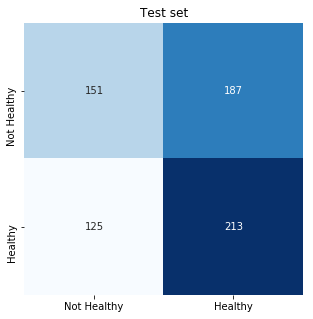

In [40]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix( label_list, pred_label_list) 
fig, ax = plt.subplots(figsize=(5,5)) 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_mtx.flatten()]
x_axis_labels=['Not Healthy',  'Healthy']
y_axis_labels=['Not Healthy',  'Healthy']  
sns.heatmap(confusion_mtx,
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#cm = ConfusionMatrixDisplay(confusion_mtx, display_labels=classes)
#cm.plot(cmap=plt.cm.Blues)
plt.title('Test set')

Text(0.5,1,'Test set')

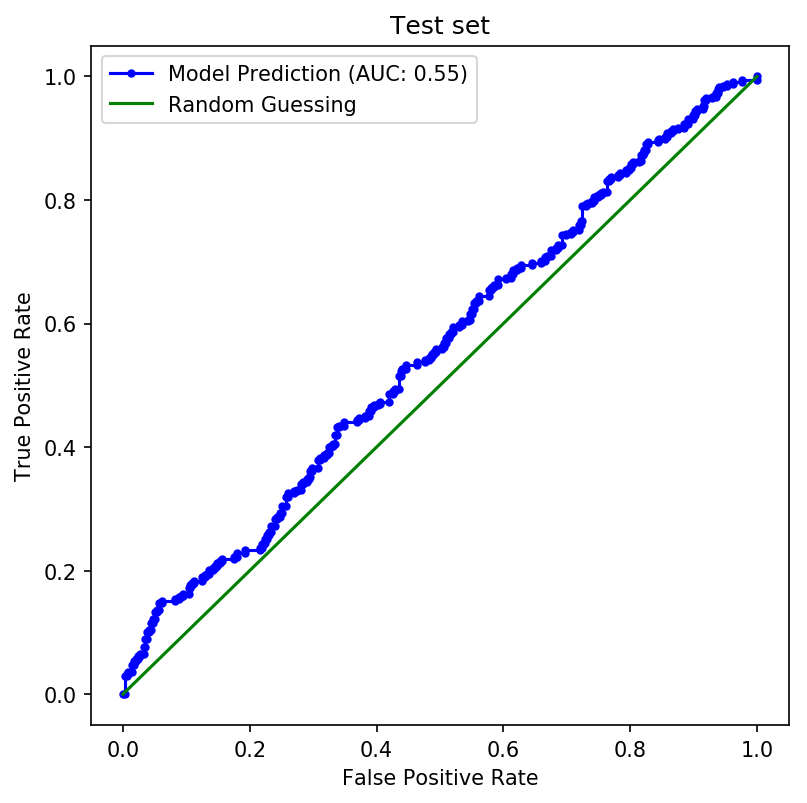

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = label_list
#sick_score = np.sum(pred_prob_list[:,1:],1)
fpr, tpr, _ = roc_curve(label_list, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
plt.title('Test set')

___

In [ ]:
#fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
#for (idx, c_ax) in enumerate(m_axs.flatten()):
#    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
#    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
#    c_ax.axis('off')
#fig.savefig('trained_img_predictions.png', dpi = 300)

In [ ]:
history.model.save('Model_Inception_3.h5')

____

### New Model